In [117]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import math
import matplotlib.pyplot as plt


"""
_______________________________________________________________________________________________
"""

class GrowthFunction:
    def __init__(self, h=0.73, omega_m=0.27, omega_l=0.73):

        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.H_0=((h*100*u.km*u.s**-1*u.Mpc**-1).to(u.Gyr**-1)).value
    
    """
    We need to create a growth factor function. Which depends on the cosmological model.
    1) find the evolution of the densities
    2) define the growth factor
    """

    def Time(self, z):
        return 2/3/(1+z)**(3/2)/self.H_0

    #hubble
    def E_of_z(self, redshift):
        """
        E(z) which describe the evolution of H(z)=E(z)*H0
        """
        Ez = (self.omega_l0 + (1.0 - self.omega_l0 
            - self.omega_m0) * (1.0+redshift)**2 
            + self.omega_m0 * (1.0+redshift)**3)**(1/2)

        return Ez

    #matter
    def omega_mz(self,redshift):
        return self.omega_m0 * (1.0+redshift)**3 / self.E_of_z(redshift)**2.0

    #Vacuum
    def omega_lz(self,redshift):
        return self.omega_l0 / (self.E_of_z(redshift))**2

    def g_of_z(self, redshift):
        """
        growth linear factor
        """

        gz = 2.5 * self.omega_mz(redshift) / (self.omega_mz(redshift)**(4/7) 
        - self.omega_lz(redshift) + ((1 + self.omega_mz(redshift)/2) 
        * (1 + self.omega_lz(redshift)/70)))

        return gz

    def D_of_z(self, redshift):
        """
        growth function
        """
        return self.g_of_z(redshift) / self.g_of_z(0.0) / (1.0+redshift)
    
    def Delta_c(self, redshift):
        return 1.686/self.D_of_z(redshift)


"""
_______________________________________________________________________________________________
"""

class Overdensities:
    
    def __init__(self,redshift=0, h7=1.05 ,h=0.73, omega_m=0.27, omega_l=0.73, ns=0.95, sigma8=0.8, Nbins_Sigma=50, logmass_lim=(4, 20)):

        if (h<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h should be in units of 100 km/s/Mpc.\n")
        if (h7<=0.0):
            raise ValueError("Overdensities(): Negative Hubble constant illegal.\n")
        elif (h7>2.0):
            raise ValueError("Overdensities(): Reduced Hubble constant h7 should be in units of 70 km/s/Mpc.\n")
        if (redshift<=-1.0):
            raise ValueError("Overdensities(): Redshift < -1 is illegal.\n")
        elif (redshift>4000.0):
            raise ValueError("Overdensities(): Large redshift entered.  TF may be inaccurate.\n")

        Growth = GrowthFunction(omega_m = omega_m, omega_l = omega_l)

        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.h7=h7
        self.h=h
        self.Nbins_Sigma = Nbins_Sigma
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.rho_0 =133363631951.67577
        #WMAP pivot scale
        self.kpivot = 2e-3

        self.D_of_z = Growth.D_of_z
        self.g_of_z = Growth.g_of_z

        #Normalization of the power spectrum
        self.N=1
        self.N=sigma8*sigma8 / (self.Sigma_of_R(self.TopHatFilter, 11.4))**2
        

        # output arrays
        # Smother radius [Mpc/h]
        self.R = np.empty(self.Nbins_Sigma,dtype='float64')
        # mass (M_sun/h)
        self.M = np.empty(self.Nbins_Sigma,dtype='float64')
        self.logM = np.empty(self.Nbins_Sigma,dtype='float64')
        #self.M = np.logspace(self.logmass_min, self.logmass_max, self.Nbins_Sigma)
        # sigma(M, z=0, where mass is in [M_sun/h])
        # array of sigma for three different filters
        self.Sigmas = np.empty(3, dtype=object)
        self.Sigmasz = np.empty(3, dtype=object)
        self.interpolates = np.empty(3, dtype=object)

        #we can initialize sigma(M) for the different filter to then interpolate
        self.Filters = (self.TopHatFilter, self.GaussianFilter, self.KSharpFilter)
        self.Ints = np.empty(3, dtype=object)

        for i in range(3):

            s, self.R = self.SigmaM_Array(self.Filters[i])
            self.Sigma = s
            self.Sigmas[i] = s
            sz = self.SigmaM_of_z()
            self.Sigmaz = sz
            self.Sigmasz[i] = sz
            interpolate = self.Interpolator()
            self.interpolates[i] = interpolate
            int = self.Sigma_of_M_and_z(self.M, interpolate)
            self.Ints[i] = int

    """
    Main function 
    Change filter if needed (self.GaussianFilter <-> self.KSharpFilter <-> self.TopHatFilter)
    _______________________________________________________________________________________________
    """
    def S(self, m):
        s = np.vectorize(self.S_prep)
        return s(m)

    def S_Z(self, m, z):
        sz = self.D_of_z(z)*self.S(m)
        return sz

    def S_Z_interpolate(self, m, z, interpolate):
        return self.D_of_z(z)*interpolate(np.log10(m))


    """
    _______________________________________________________________________________________________
    """

    
    def S_prep(self, m):
        gamma_f, c = (2*np.pi)**(2/3), 0.643
        R = c*(m/(gamma_f*self.rho_0))**(1/3)
        s = integrate.quad(self.integrant, 0, np.inf, args=(R, self.GaussianFilter), epsrel=1e-2, limit=100)[0]
        return (s/(2*np.pi**2))**(1/2)

    def TransferFunction(self, k):
        q=2.04/(self.omega_m0*self.h7**2)
        return np.log(1+2.34*q*k)/(2.34*q*k*(1+3.89*q*k+(16.1*q*k)**2+(5.46*q*k)**3+(6.71*q*k)**4)**(1/4))
    
    def PowerSpectrum(self, k):
        return self.N * self.TransferFunction(k)**2 * k * (k/self.kpivot)**(self.ns-1)
    
    """
    Now we define each filters. 
    Using the series expansion at low Rk make the integration more precised (for numerical integration).
    """

    def TopHatFilter(self, x):
        if x < 1e-2:
            return 1-x**2/10+x**4/280
            # return 1./3. - x**2/30. +x**4/840
        else:
            return 3/(x)**3*(np.sin(x)-x*np.cos(x))
        
    def GaussianFilter(self, x):
        if x < 1e-2:
            return 1-x**2/2+x**4/8
        else:
            return np.exp(-x**2/2)
        
    def KSharpFilter(self, x):
        if x <= 1:
            return 1
        else:
            return 0
    
    def integrant(self, k, R, Filter):
        return k**2*self.PowerSpectrum(k)*Filter(k*R)**2
    
    def Sigma_of_R(self, Filter, R):

        s2 = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter), epsrel=1e-4, limit=100)[0]
        
        return (s2/(2*np.pi**2))**(1/2)

    def Sigma_of_M(self, Filter, M):

        if Filter == self.TopHatFilter:
            gamma_f, c = 4*np.pi/3, 1
        
        elif Filter == self.GaussianFilter:
            gamma_f, c = (2*np.pi)**(2/3), 0.643
        
        elif Filter == self.KSharpFilter:
            gamma_f, c = 6*np.pi**2, 1

        R = c*(M/(gamma_f*self.rho_0))**(1/3)

        s = integrate.quad(self.integrant, 0, np.inf, args=(R, Filter,), epsrel=1e-4, limit=200)[0]

        return (s/(2*np.pi**2))**(1/2), R
    
    def SigmaM_Array(self, Filter):
        
        s = np.empty(self.Nbins_Sigma, dtype='float64')
        R = np.empty(self.Nbins_Sigma, dtype='float64')

        dm = (self.logmass_max - self.logmass_min)/self.Nbins_Sigma

        for i in range(self.Nbins_Sigma):

            logM = self.logmass_min + i*dm

            M = 10.0**logM

            s[i], R[i]= self.Sigma_of_M(Filter, M)

            self.M[i] = M

            self.logM[i] = logM

        return s, R


    """The final function is ready to be set up"""

    def Interpolator(self):
        return scipy.interpolate.InterpolatedUnivariateSpline(self.logM, self.Sigma)

    def SigmaM_of_z(self):
        sz = self.D_of_z(self.redshift)*self.Sigma
        return sz

    def Sigma_of_M_and_z(self, M, interpolate):
        return self.D_of_z(self.redshift)*interpolate(np.log10(M))

"""
_______________________________________________________________________________________________
"""

class HaloMassFunction:

    def __init__(self, redshift, omega_m=0.27, omega_l=0.73, h=1.05, ns=0.95, sigma8=0.8, mass_function=None, Nbins=50, logmass_lim=(6, 20)):
        self.overden = Overdensities(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins_Sigma=Nbins, logmass_lim=logmass_lim)
        self.logM=self.overden.logM
        self.M = self.overden.M
        self.interpolates=self.overden.interpolates

        if mass_function == None:
            self.mass_function = self.press_schechter
        else:
            self.mass_function = mass_function.__get__(self)

        self.redshift = redshift
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c

        self.S = self.overden.S

        self.dndms=np.empty(3, dtype=object)

        for i in range(3):

            dndm=self.dndm_gen(self.M, self.interpolates[i])

            self.dndms[i] = dndm

    """
    Main function 
    _______________________________________________________________________________________________
    """
    def IMF(self, m, z):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative(m)
        mass_func = self.press_schechter_z(sigma, z)
        
        IMF = np.abs(dlogsigma)*mass_func/m*rho_0

        return IMF
    """
    _______________________________________________________________________________________________
    """

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(M+10)
        return M/sigma/sigma*(sigma_plus*sigma_plus-sigma*sigma)/10, sigma

    def logderivative_filter(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(1.1*np.log10(M))
        return (np.log(sigma_plus*sigma_plus)-np.log(sigma*sigma))/np.log(0.1*M), sigma
        
    
    def dndm_gen(self, M, interpolate):
        """Returns the halo mass function dn/dM in units of h^4 M_sun^-1 Mpc^-3
        Requires mass in units of M_sun /h """
        # Mean matter density at redshift z in units of h^2 Msolar/Mpc^3
        #This is rho_c in units of h^-1 M_sun (Mpc/h)^-3
        rho_0 = self.overden.rho_0 #self.overden.omega_matter_of_z(self.overden.redshift)

        dlogsigma, sigma = self.logderivative_filter(M, interpolate)
        mass_func = self.mass_function(sigma)
        
        dndM =  np.abs(dlogsigma)*mass_func/M*rho_0

        return dndM

    def press_schechter_z(self, sigma, z):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(z) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def press_schechter(self, sigma):
        """Press-Schechter (This form Lacey and Cole eq. 2.11 1993)"""
        nu = self.Delta_c(self.redshift) / sigma
        return np.sqrt(1/2*np.pi) * nu * np.exp(-0.5*nu*nu)

    def sheth_tormen(self, sigma):
        """Sheth-Tormen 1999, eq. 6"""
        nu = self.Delta_c(self.redshift) / sigma
        A=0.3222
        a=0.707
        p=0.3
        return A*np.sqrt(2.0*a/math.pi)*(1.0+ np.power( 1.0/(nu*nu*a), p) )*  nu * np.exp(-0.5*a*nu*nu)

    def warren(self, sigma):
        """LANL fitting function - Warren et al. 2005, astro-ph/0506395, eqtn. 5 """
        A = 0.7234
        a = 1.625
        b = 0.2538
        c = 1.1982
        return A*( np.power(sigma, -1.0*a) + b)*np.exp(-1.0*c / sigma / sigma )

    def watson_FOF(self, sigma):
        """Watson 2012, eq. 12"""
        A = 0.282
        a = 2.163
        b = 1.406
        c = 1.210
        return A*( np.power(b / sigma, 1.0*a) + 1)*np.exp(-1.0*c / sigma / sigma )

"""
_______________________________________________________________________________________________
"""



'\n_______________________________________________________________________________________________\n'

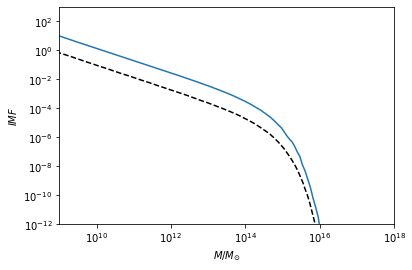

In [91]:
Fig, bx = plt.subplots(figsize=(6,4))
HIMF=HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

m = np.logspace(4, 18, 200)

bx.plot(m, HIMF.IMF(m, 0))
bx.set_xscale('log')
bx.set_xlabel('$M/M_{\odot}$')
bx.set_ylabel('$IMF$')
bx.set_yscale('log')
bx.set_ylim(1e-12,1e3)
bx.set_xlim(1e9,1e18)
path = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/'

data = np.genfromtxt(path + 'Binney,Tremaine.csv', delimiter=';')
bx.plot(data[:,0], data[:,1], 'k--', label = 'Binney and Tremaine 2006')

In [ ]:

class MergerRate:
    def __init__(self, redshift, redshift_lim = (0, 12), M_1=5e13, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8, Nbins=50, logmass_lim=(6, 20)):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.logmass_lim = logmass_lim
        self.sigma8 = sigma8
        self.h=h
        self.Nbins = Nbins
        self.ns = ns
        self.redshift = redshift
        self.logmass_max = logmass_lim[1]
        self.logmass_min = logmass_lim[0]
        self.rho_0 = self.omega_m0 * 2.78e+11
        self.M_1=M_1
        self.redshift_max_lim = redshift_lim[1]
        self.redshift_min_lim = redshift_lim[0]
        #self.rho_0 =133363631951.67577


        self.HMF = HaloMassFunction(redshift, omega_m=omega_m, omega_l=omega_l, h=h, ns=ns, sigma8=sigma8, Nbins=Nbins, logmass_lim=logmass_lim)
    
        Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l)

        self.Delta_c = Growth.Delta_c
        self.Time = Growth.Time

        overden = Overdensities(0, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        self.S=overden.S



    """Create a merger rate at a fixed final mass in terms of the redshift"""

    def MergerRate_M_Z(self, M2, M1, Z):

        der, sigma2 = self.logderivative(M2)
        sigma1 = self.S(M1)

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR
    
    def MergerRate_M_Z2(self, M2, M1, Z):

        interpolate = self.overden.interpolates[1]

        der, sigma2 = self.derivative2(M2, interpolate)
        sigma1 = interpolate(np.log10(M1))

        MR = M2/(2*np.pi)**(1/2)*np.abs(2/3*self.Delta_c(Z)/self.Time(Z)*der)*((sigma1/sigma2)**2/(sigma1**2-sigma2**2))**(3/2)*np.exp(-0.5*self.Delta_c(Z)**2*(1/sigma2**2-1/sigma1**2))

        return MR
    
    def MR_Sommerville(self, M1, z1, M0, z0):
        f=1/np.sqrt(2*np.pi)*(self.Delta_c(z1)-self.Delta_c(z0))/(self.S(M1)-self.S(M0))**(3/2)*np.exp((self.Delta_c(z1)-self.Delta_c(z0))**2/(2*self.S(M1)-2*self.S(M0)))
        return M0/M1*f*np.abs(self.logderivative(M0)[0])


    """Create a merger rate at a fixed redshift in terms of the mass"""
    def MergerRate_of_M2(self):
        
        overden = Overdensities(self.redshift, omega_m=self.omega_m0, omega_l=self.omega_l0, h=self.h, ns=self.ns, sigma8=self.sigma8, 
        Nbins_Sigma = self.Nbins, logmass_lim=self.logmass_lim)

        interpolate = overden.interpolates[1]

        DeltaM = np.empty(self.Nbins, dtype=object)
        LogdeltaM = np.empty(self.Nbins, dtype=object)

        MR = np.empty(self.Nbins, dtype=object)

        logDMmin = -2
        logDMmax = 2
        sigma1 = interpolate(np.log10(self.M_1))
        dlogm = (logDMmax-logDMmin)/self.Nbins

        for i in range(self.Nbins):

            thislogDM = logDMmin + i*dlogm
            thisDM = 10**(thislogDM)*self.M_1
            thisM2 = thisDM + self.M_1

            der , sigma2 = self.logderivative2(thisM2, interpolate)

            MR[i] = 3/1e-3*(2/np.pi)**(1/2)/self.Time(self.redshift)*2/3*thisDM/thisM2*np.abs(der)*self.Delta_c(self.redshift)/sigma2/(1-(sigma2/sigma1)**2)**(3/2)*np.exp(-0.5*self.Delta_c(self.redshift)**2*(1/sigma2**2-1/sigma1**2))
            DeltaM[i] = thisDM
            LogdeltaM[i] = thislogDM

        return MR, DeltaM, LogdeltaM

    def logderivative(self, M):
        sigma = self.S(M)
        sigma_plus = self.S(1.00000000001*M)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma

            
    def logderivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.1*M))
        return (np.log(sigma_plus)-np.log(sigma))/np.log(0.1*M), sigma
    
    def derivative2(self, M, interpolate):
        sigma = interpolate(np.log10(M))
        sigma_plus = interpolate(np.log10(1.00000000001*M))
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.00000000001*M), sigma
    
    def Delta_c_derivative(self, z):
        DT = self.Delta_c(z)
        DTplus = self.Delta_c(1.0001*z)
        return (DTplus-DT)/0.0001*z

In [92]:
from scipy.stats import norm
class MergerTree:

    def __init__(self, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.sigma8 = sigma8
        self.h = h
        self.ns = ns
        self.rho_0 = self.omega_m0 * 2.78e+11

        self.overdensity = Overdensities(0, omega_l=omega_l, omega_m=omega_m, h=h, sigma8=sigma8, ns=ns)
        self.MergerRate = MergerRate(0, omega_l=omega_l, omega_m=omega_m, ns=ns, h=h, sigma8=sigma8)
        self.Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l, h=h)

        self.sigma = self.overdensity.S
        self.Delta_c = self.Growth.Delta_c

        m = np.logspace(0, 16, 1000)
        sig = self.sigma(m)
        int = scipy.interpolate.InterpolatedUnivariateSpline(m, sig)
        self.sigma_int = np.vectorize(int)

    def MT_Routine(self, M0, z0, z_m):

        Ms = []
        DM=M0
        # Ml = 10**(np.log10(M0)-4)
        
        Ml=10**4
        
        i=0

        while DM>Ml:
            
            # Ml = 10**(np.log10(DM)-4)
            # sigma_c = self.Delta_c(z_m)
            # M_c = self.M_finder(sigma_c**(-3/2)*DM, sigma_c)

            # domegaC = 0.8+0.3*np.log10(DM/Ml)*self.OmegaStep(DM, DM-M_c)

            domegaC = self.Delta_c(z_m)-self.Delta_c(z0)

            M = self.M_picker(DM, domegaC)

            DM=DM-M

            if M>Ml:
                Ms.append(M)
                i+=1
                
            if i==2:
                break
            
        # M_acc = M_and_z[0]-np.sum(np.array(Ms))

        return Ms


    def M_picker(self, M0, domega):

        i=0

        while i<1:
            
            # domega = np.random.uniform(0, domega)

            x_output = np.abs(np.random.normal(0,1))

            dS = (domega/(2*x_output))**2
            
            if dS<(domega/2)**2:
                i+=1

        S = self.sigma(M0)**2+dS

        return self.M_finder(M0, S)
    
    # def Delta_Z(self, num_points):

    #     z = np.linspace(10, 30, 100)
    #     y = self.Delta_c(z)
    #     z_int = scipy.interpolate.interp1d(y, z)
    #     y_interp = np.linspace(y[0], y[-1], num_points)

    #     return z_int(y_interp)


    def M_finder(self, M0, S):
        return float(scipy.optimize.fsolve(self.S_for_M, M0, args=S))
        
    def S_for_M(self, M, S):
        return self.sigma_int(M)**2-S
    
    def derivative(self, M):
        sigma = self.sigma(M)
        sigma_plus = self.sigma(M+0.000000001)
        return (sigma_plus*sigma_plus-sigma*sigma)/(0.000000001*M)
    
    def z_finder(self, z_0, domega):
        Df = self.Delta_c(z_0)+domega
        return float(scipy.optimize.fsolve(self.Delta_c_for_z, z_0, args=Df))

    def Delta_c_for_z(self, z, D_z_f):
        return self.Delta_c(z)-D_z_f

    def OmegaStep(self, M0, dMc):
        return np.sqrt(np.abs(self.derivative(M0))*dMc)

In [88]:
z=np.linspace(0, 30, 100)
MT = MergerTree()
sigma_star = MT.Delta_c(z)/3
M = np.zeros(len(z))
for i in range(len(M)):
    M[i] = np.log10(MT.M_finder(10**(4), sigma_star[i]**2))


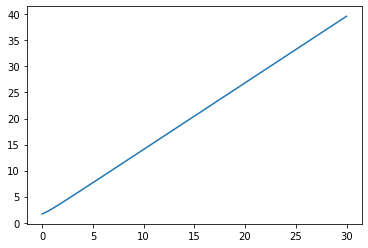

In [10]:
z=np.linspace(0, 30,100)
plt.plot(z, MT.Delta_c(z))

In [11]:
MT.sigma(10**4)

array(10.36491526)

(0.0, 30.0)

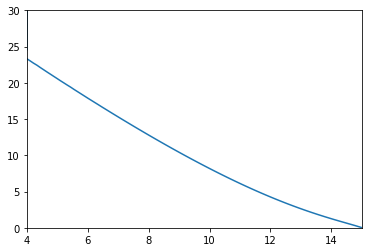

In [89]:
plt.plot(M, z)
plt.xlim(4, 15)
plt.ylim(0, 30)

In [82]:
import time 
t0 = time.time()
MT = MergerTree()
for i in range(20):
    Ms = MT.MT_Routine(1e12, 10, 11.5)
    # print(np.sum(Ms)+M_acc)
    print(Ms)
    print(time.time()-t0)

[757704520689.4758, 177483750979.00146]
1.5808908939361572
[609628746803.4176, 340201153929.1171]
1.585566759109497
[642688249433.758, 219265772656.08325]
1.589406967163086
[601972072273.8002, 315761156036.7358]
1.594449758529663
[748650750640.2084, 192595058439.82956]
1.5992629528045654
[770282515743.4156, 194996436938.4463]
1.6039297580718994
[774199443205.5637, 150412582211.30682]
1.608832836151123
[568227259005.8254, 340267182387.6036]
1.6142747402191162
[629382365848.3195, 294735888623.99976]
1.6200377941131592
[900224889878.9766, 81672490955.69565]
1.6252737045288086
[947604615597.236, 42980094475.798996]
1.6316938400268555
[815488565551.0787, 118885695281.55667]
1.636333703994751
[772150857809.6383, 183267833715.8087]
1.641770839691162
[583195563345.8069, 364475753029.02905]
1.647054672241211
[561861299796.5614, 286620645885.32434]
1.6517739295959473
[744497552174.6581, 187966140869.527]
1.6564557552337646
[645166316430.4021, 285081866074.4339]
1.6605868339538574
[708531092894.7

In [14]:
from itertools import chain

mfinder = np.vectorize(MT.M_finder)

In [84]:
n_halos=1000

Halos =[4.14192626e+04, 1.30983541e+04, 2.34212951e+06, 2.70304337e+05,
       4.25275348e+06, 1.55697850e+05, 5.95238475e+05, 8.64868135e+05,
       2.40002323e+09, 8.58108271e+04, 6.30215097e+06, 5.16754663e+04,
       3.65909688e+07, 2.56068476e+04, 2.73310120e+05, 9.01183149e+04,
       5.27713252e+05, 1.71776023e+06, 1.35785260e+07, 6.64251958e+04,
       5.26413919e+05, 5.00285807e+04, 7.14737891e+07, 3.11841808e+04,
       4.35671325e+06, 3.27777166e+05, 1.69701085e+04, 5.59917758e+05,
       2.35281701e+04, 4.08792949e+08, 5.85657292e+05, 1.76794568e+06,
       4.88613040e+06, 6.15386295e+08, 1.17603503e+05, 1.91157216e+04,
       7.16393453e+06, 8.43446419e+04, 2.48967080e+06, 1.18024885e+04]

In [93]:
Halos = [9.86640562e+04, 7.88075813e+05, 6.14431738e+05, 1.21376672e+04,
       1.91966193e+07, 1.05991750e+08, 1.67898300e+07, 2.27681725e+06,
       8.34027592e+08, 1.30816293e+09, 4.23758826e+04, 7.50409515e+06,
       1.72619593e+05, 2.64746767e+04, 1.11759717e+07, 2.17346202e+06,
       2.97093554e+07, 4.51507389e+04, 2.98682052e+05, 1.80820095e+04,
       6.62458830e+06, 3.83615185e+04, 9.89560113e+04, 1.22585248e+05,
       1.42961774e+05, 2.63179764e+08, 1.60792785e+05, 2.06589733e+05,
       2.98069549e+04, 1.70607890e+04, 1.29345310e+05, 1.09201928e+04,
       1.54035339e+04, 2.34124372e+05, 1.29138971e+07, 1.16956386e+07,
       1.10804425e+06, 2.06056938e+05, 1.53475291e+07, 8.35384757e+08,
       4.94699042e+08, 1.00257743e+04, 5.14428137e+04, 2.49289494e+08,
       7.60446400e+05, 2.19028368e+08, 2.05594233e+04, 2.97387607e+04,
       2.64473879e+07, 1.55156352e+07, 3.71082872e+05, 1.04642558e+06,
       5.39009904e+08, 5.51117375e+04, 2.59112552e+06, 3.17381970e+04,
       3.42235396e+06, 2.66847514e+04, 5.02537174e+06, 1.58875170e+05,
       4.94314258e+04, 2.77585225e+04, 2.48085402e+05, 1.15947082e+09,
       4.58056282e+06, 1.05409837e+05, 3.92249407e+09, 1.36388391e+06,
       1.94164883e+04, 4.63091263e+05, 3.39812306e+05, 2.08073910e+08,
       1.89034952e+04, 2.84498596e+04, 5.34485977e+04, 2.84868923e+05,
       1.19808563e+05, 4.91163199e+06, 3.47516310e+05, 1.05527422e+05,
       8.35038140e+04, 6.09815406e+05, 4.78994044e+07, 2.45939135e+04,
       6.85236861e+07, 2.41129889e+05, 1.56051439e+04, 8.59796297e+04,
       9.28710673e+04, 7.45876380e+06, 6.38612648e+04, 1.65522443e+05,
       2.53778946e+07, 1.05756183e+06, 4.04922803e+06, 2.82836514e+06,
       2.89608106e+06, 1.15018880e+04, 2.62478471e+06, 5.47533247e+06]

In [94]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 10, 100)

In [95]:
def halo_PDF_norm(z):
    return integrate.quad(HIMF.IMF, 10**3, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]

In [96]:
Himf_0 = HIMF.IMF(m, 0)/halo_PDF_norm(0)

<ipython-input-95-88f75843171e>:2: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(HIMF.IMF, 10**3, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]


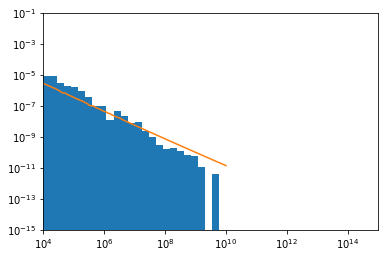

In [101]:
plt.hist(Halos, density=True, bins=10**np.linspace(4, 13, 40))
M=np.logspace(4, 10, 100)
plt.plot(M, Himf_0)
plt.xlim(10**4, 10**15)
plt.ylim(1e-15,1e-1)
plt.xscale('log')
plt.yscale('log')

In [103]:
MT = MergerTree()
z=0
Ms= Halos
print(z)

0


In [104]:
t0 = time.time()
while z<4:
    
    Mss=[]
    for ii in range(len(Ms)):
        routine = MT.MT_Routine(Ms[ii], z, z+0.02)
        Mss.append(routine)
        
    z=z+0.02
    Mss = list(chain.from_iterable(Mss))
    Ms = Mss
    print(z)
    print(time.time()-t0, len(Ms))

0.02
0.27187037467956543 104
0.04
0.5117230415344238 108
0.06
0.7593991756439209 112
0.08
1.074923038482666 117
0.1
1.354154348373413 121
0.12000000000000001
1.6420531272888184 126
0.14
1.943960189819336 131
0.16
2.2605533599853516 136
0.18
2.592531204223633 140
0.19999999999999998
2.9284591674804688 146
0.21999999999999997
3.279771327972412 151
0.23999999999999996
3.661954164505005 154
0.25999999999999995
4.047121286392212 157
0.27999999999999997
4.423201084136963 161
0.3
4.808101177215576 164
0.32
5.249204397201538 168
0.34
5.649657249450684 172
0.36000000000000004
6.064992189407349 179
0.38000000000000006
6.495755195617676 184
0.4000000000000001
6.935635328292847 188
0.4200000000000001
7.411616086959839 192
0.4400000000000001
7.889668226242065 196
0.46000000000000013
8.36202335357666 201
0.48000000000000015
8.88216233253479 206
0.5000000000000001
9.383708238601685 211
0.5200000000000001
9.892665147781372 216
0.5400000000000001
10.421001434326172 222
0.5600000000000002
10.96082925796

In [22]:
len(Ms)

2613

In [102]:
HIMF=HaloMassFunction(0)
m = np.logspace(4, 10, 100)
Himf = HIMF.IMF(m, 4)/np.abs(halo_PDF_norm(4))
Himf

<ipython-input-95-88f75843171e>:2: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(HIMF.IMF, 10**3, 10**10, args=(z), epsrel=1e-4, limit=1000)[0]


array([3.99325592e-06, 3.50034500e-06, 3.04984890e-06, 2.68471291e-06,
       2.44161143e-06, 2.08353670e-06, 1.92334681e-06, 1.63025681e-06,
       1.42459980e-06, 1.24256719e-06, 9.82722546e-07, 9.09048383e-07,
       9.01480462e-07, 7.46914646e-07, 6.53397160e-07, 5.72336327e-07,
       5.08402316e-07, 4.37012722e-07, 3.84884765e-07, 3.51194324e-07,
       2.98464100e-07, 2.74625739e-07, 2.33464419e-07, 2.04006964e-07,
       1.77822248e-07, 1.37568328e-07, 1.30592929e-07, 1.27788346e-07,
       1.06871314e-07, 9.34822571e-08, 8.18605378e-08, 7.26179778e-08,
       6.32331451e-08, 5.49987687e-08, 5.03470868e-08, 4.26201207e-08,
       3.90186083e-08, 3.33240164e-08, 2.91612596e-08, 2.55525637e-08,
       2.25057458e-08, 2.03196177e-08, 1.81553111e-08, 1.51955802e-08,
       1.32807544e-08, 1.16387904e-08, 1.02096000e-08, 8.96519115e-09,
       7.86486226e-09, 6.90221910e-09, 6.05537863e-09, 5.31027018e-09,
       4.65115236e-09, 4.08204543e-09, 3.57896302e-09, 3.13733605e-09,
      

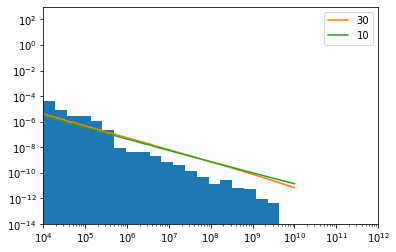

In [108]:
plt.hist(Ms, bins=10**np.linspace(4,15,40), log=True, density=True)
plt.plot(m, Himf, label='30')
plt.plot(m, Himf_0, label='10')
plt.ylim(1e-14,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e4, 1e12)
plt.legend()

In [25]:
len(Ms)

2613

In [121]:
from scipy.stats import norm
class MergerTree_2:

    def __init__(self, M_res, omega_m=0.27, omega_l=0.73, h=0.73, ns=0.95, sigma8=0.8):
        self.omega_m0 = omega_m
        self.omega_l0 = omega_l
        self.sigma8 = sigma8
        self.h = h
        self.ns = ns
        self.rho_0 = self.omega_m0 * 2.78e+11

        self.overdensity = Overdensities(0, omega_l=omega_l, omega_m=omega_m, h=h, sigma8=sigma8, ns=ns)
        self.MergerRate = MergerRate(0, omega_l=omega_l, omega_m=omega_m, ns=ns, h=h, sigma8=sigma8)
        self.Growth = GrowthFunction(omega_m=omega_m, omega_l=omega_l, h=h)

        self.sigma = self.overdensity.S
        self.Delta_c = self.Growth.Delta_c

        m = np.logspace(0, 16, 1000)
        sig = self.sigma(m)
        int = scipy.interpolate.InterpolatedUnivariateSpline(m, sig)
        self.sigma_int = np.vectorize(int)

        self.M_res = M_res

    def MT_routine(self, M0, z0):

        dz = 1

        P = self.P(z0, M0, dz)
        print(P)

        while P>0.01:
            dz = 0.01/(P/dz)
            P = P*dz
            print('routine', dz)

        R = np.random.uniform(0,1)
        F = self.F(z0, M0, dz)

        if R>P:
            M0 = M0*(1-F)
            M1=0

        else:
            M1 = self.M_gen(z0, M0, dz)
            M0 = M0*(1-F) - M1
        
        z = z0+dz

        return M0, M1, z


    def M_gen(self, M_res, z1, M2, dz):

        fmax = self.dNdM1(0.9*M_res/2, z1, M2, dz)

        ii=0

        while ii<1:

            x = np.random.uniform( M_res, M2/2, 100)
            y = np.random.uniform(0, fmax, 100)

            x_accepted = x[(y <= self.dNdM1(x, z1, M2, dz))]
            ii+=len(x_accepted)

            print('gen')
        
        return x_accepted[:1][0]
    
    def Normalizer(self, M0, z1, dz):
        return integrate.quad(self.dNdM1, self.M_res, M0/2, args=(z1, M0, dz))


    def P(self, M1, z1, M0, z0):

        s1 = self.sigma(M1)
        s0 = self.sigma(M0)

        d_delta = self.Delta_c(z1)-self.Delta_c(z0)

        P = 1/np.sqrt(2*np.pi) * d_delta / (s1**2-s0**2)**(3/2) * np.exp(-(d_delta)**2 / 2 / (s1-s0))

        return P
    
    def phi(self, M1, z1, M0, z0):

        phi = M0/M1 * self.P(M1, z1, M0, z0)

        return phi

In [122]:
MT2 = MergerTree_2(1e4)

M0 = 1e8

scipy.integrate.quad(MT2.phi, M0/2, M0, args = (0.02, M0, 0))

<ipython-input-122-c26f7fee8ef5>:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scipy.integrate.quad(MT2.phi, M0/2, M0, args = (0.02, M0, 0))


(5287119.995077832, 0.09218566591499834)

26